# Task 6C: Text Analysis Challenge

#### Barbara Rein Calma
#### s224712709
#### barbarareincalma@gmail.com

#### undergraduate

In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# --- CONFIG ---
DATA_DIR = Path('.')  # change if your CSVs are in a different folder

def load_csv(filename: str) -> pd.DataFrame:
    path = DATA_DIR / filename
    assert path.exists(), f"Missing required file: {path.resolve()}"
    df = pd.read_csv(path)
    print(f"Loaded {filename}: {df.shape}")
    return df

posts = load_csv('Posts.csv')
comments = load_csv('Comments.csv')
tags = load_csv('Tags.csv')
votes = load_csv('Votes.csv')

Loaded Posts.csv: (78926, 22)
Loaded Comments.csv: (82370, 7)
Loaded Tags.csv: (702, 5)
Loaded Votes.csv: (222642, 6)


#### Q1: Understanding the Tables and Their Relationships

For this question, I explored each of the four CSV files to understand what they contain and how they connect to each other.

The **Posts** table is the main table and contains both questions and answers. I can tell them apart using the `PostTypeId` column, where 1 means it's a question and 2 means it's an answer. Questions have titles and tags, while answers link back to their parent question through `ParentId`.

The **Comments** table stores all the comments people leave on posts. Each comment links to a post using the `PostId` column, which matches the `Id` in the Posts table.

The **Votes** table records every vote that happens on the site. Like comments, votes connect to posts through `PostId`. The `VoteTypeId` tells us what kind of vote it was.

The **Tags** table is a dictionary of all the tags used on the site. Tags connect to questions through the `Tags` column in Posts, which stores them as a pipe-delimited string like `|machine-learning|python|`.

Overall, the Posts table sits at the center, with Comments and Votes linking to it by `PostId`. Tags are extracted from the question text and matched against this dictionary. Below I preview each table to see the column types and sample data.

In [2]:
def preview(df, name, n=3):
    print(f"\n== {name} ==")
    display(df.head(n))
    print(df.dtypes)

preview(posts, 'Posts')
preview(comments, 'Comments')
preview(votes, 'Votes')
preview(tags, 'Tags')


== Posts ==


,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,...,ClosedDate,ContentLicense,AcceptedAnswerId,LastEditorUserId,LastEditDate,ParentId,OwnerDisplayName,CommunityOwnedDate,LastEditorDisplayName,FavoriteCount
0,5,1,2014-05-13T23:58:30.457,9,968.0,<p>I've always been interested in machine lear...,5.0,2014-05-14T00:36:31.077,How can I do simple machine learning without h...,|machine-learning|,...,2014-05-14T14:40:25.950,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,1,2014-05-14T00:11:06.457,4,510.0,"<p>As a researcher and instructor, I'm looking...",36.0,2014-05-16T13:45:00.237,What open-source books (or other materials) pr...,|education|open-source|,...,2014-05-14T08:40:54.950,CC BY-SA 3.0,10.0,97.0,2014-05-16T13:45:00.237,NaN,NaN,NaN,NaN,NaN
2,9,2,2014-05-14T00:36:31.077,5,NaN,"<p>Not sure if this fits the scope of this SE,...",51.0,2014-05-14T00:36:31.077,NaN,NaN,...,NaN,CC BY-SA 3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN


Id                         int64
PostTypeId                 int64
CreationDate              object
Score                      int64
ViewCount                float64
Body                      object
OwnerUserId              float64
LastActivityDate          object
Title                     object
Tags                      object
AnswerCount              float64
CommentCount               int64
ClosedDate                object
ContentLicense            object
AcceptedAnswerId         float64
LastEditorUserId         float64
LastEditDate              object
ParentId                 float64
OwnerDisplayName          object
CommunityOwnedDate        object
LastEditorDisplayName     object
FavoriteCount            float64
dtype: object

== Comments ==


,Id,PostId,Score,Text,CreationDate,UserId,UserDisplayName
0,5,5,9,this is a super theoretical AI question. An in...,2014-05-14T00:23:15.437,34.0,NaN
1,6,7,4,List questions are usually not suited for Stac...,2014-05-14T00:38:19.510,51.0,NaN
2,9,7,3,This question appears to be off-topic because ...,2014-05-14T01:16:12.623,66.0,NaN


Id                   int64
PostId               int64
Score                int64
Text                object
CreationDate        object
UserId             float64
UserDisplayName     object
dtype: object

== Votes ==


,Id,PostId,VoteTypeId,CreationDate,UserId,BountyAmount
0,1,1,2,2014-05-13T00:00:00.000,NaN,NaN
1,2,1,2,2014-05-13T00:00:00.000,NaN,NaN
2,6,1,2,2014-05-13T00:00:00.000,NaN,NaN


Id                int64
PostId            int64
VoteTypeId        int64
CreationDate     object
UserId          float64
BountyAmount    float64
dtype: object

== Tags ==


,Id,TagName,Count,ExcerptPostId,WikiPostId
0,1,definitions,39,105.0,104.0
1,2,machine-learning,11403,4909.0,4908.0
2,3,bigdata,456,66.0,65.0


Id                 int64
TagName           object
Count              int64
ExcerptPostId    float64
WikiPostId       float64
dtype: object


#### Data Preparation

Before starting the analysis, I needed to clean and prepare the data. First, I converted the date columns to proper datetime format so I could group by year and month later. Then I split the Posts table into separate questions and answers dataframes based on `PostTypeId`.

For each question, I also calculated some useful metrics: how many answers it received, how many comments, and how many votes. These engagement numbers will help me understand which topics get the most attention from the community.


In [3]:
posts = posts.copy()
comments = comments.copy()
votes = votes.copy()

# Parse dates
for col in ['CreationDate', 'LastActivityDate', 'ClosedDate']:
    if col in posts.columns:
        posts[col] = pd.to_datetime(posts[col], errors='coerce')

comments['CreationDate'] = pd.to_datetime(comments['CreationDate'], errors='coerce')
votes['CreationDate'] = pd.to_datetime(votes['CreationDate'], errors='coerce')

# Split questions and answers
questions = posts[posts['PostTypeId'] == 1].copy()
answers   = posts[posts['PostTypeId'] == 2].copy()

# Basic time fields
questions = questions.dropna(subset=['CreationDate']).copy()
questions['year'] = questions['CreationDate'].dt.year
questions['year_month'] = questions['CreationDate'].dt.to_period('M').dt.to_timestamp()
questions['month'] = questions['CreationDate'].dt.month

# Answers per question: prefer AnswerCount if present
if 'AnswerCount' in questions.columns:
    questions['n_answers'] = questions['AnswerCount'].fillna(0)
else:
    # fallback: compute from answers.ParentId if available
    if 'ParentId' in answers.columns:
        ans_per_q = answers.groupby('ParentId')['Id'].count().rename('n_answers')
        questions = questions.join(ans_per_q, on='Id')
    questions['n_answers'] = questions.get('n_answers', 0).fillna(0)

# Comment count per post from Comments table (more reliable than Posts.CommentCount if any mismatch)
comment_counts = comments.groupby('PostId')['Id'].count().rename('n_comments')
questions = questions.join(comment_counts, on='Id')
questions['n_comments'] = questions['n_comments'].fillna(0)

# Vote count per post from Votes table
vote_counts = votes.groupby('PostId')['Id'].count().rename('n_votes')
questions = questions.join(vote_counts, on='Id')
questions['n_votes'] = questions['n_votes'].fillna(0)

questions[['Id','CreationDate','Score','ViewCount','n_answers','n_comments','n_votes']].head()

,Id,CreationDate,Score,ViewCount,n_answers,n_comments,n_votes
0,5,2014-05-13 23:58:30.457,9,968.0,1.0,1.0,15.0
1,7,2014-05-14 00:11:06.457,4,510.0,3.0,4.0,15.0
4,14,2014-05-14 01:25:59.677,26,1931.0,4.0,1.0,38.0
5,15,2014-05-14 01:41:23.110,2,657.0,0.0,1.0,8.0
6,16,2014-05-14 01:57:56.880,17,436.0,2.0,0.0,20.0


#### Extracting Tags from Questions

The `Tags` column in the Posts table stores tags as a pipe-delimited string, like `|machine-learning|python|deep-learning|`. To analyse which topics are popular, I needed to split this string and create a separate row for each tag associated with a question. I used pandas string methods to split on the pipe character and then exploded the list so each question-tag pair becomes its own row. This makes it much easier to count and group by tags later on.

In [4]:
assert 'Tags' in questions.columns, "Expected a 'Tags' column in Posts.csv."

q_tags = questions[['Id','CreationDate','year','year_month','Tags']].copy()
# Tags are pipe-delimited: |tag1|tag2| — extract all non-empty segments
q_tags['tag'] = q_tags['Tags'].fillna('').astype(str).str.split('|').apply(lambda x: [t for t in x if t])
q_tags = q_tags.explode('tag').dropna(subset=['tag']).rename(columns={'Id':'question_id'})

# Optional: join tag dictionary (sanity check / metadata)
q_tags = q_tags.merge(tags[['Id','TagName','Count']], left_on='tag', right_on='TagName', how='left', suffixes=('','_tagdict'))

print(q_tags.shape)
q_tags.head()

(113074, 9)


,question_id,CreationDate,year,year_month,Tags,tag,Id,TagName,Count
0,5,2014-05-13 23:58:30.457,2014,2014-05-01,|machine-learning|,machine-learning,2,machine-learning,11403
1,7,2014-05-14 00:11:06.457,2014,2014-05-01,|education|open-source|,education,39,education,34
2,7,2014-05-14 00:11:06.457,2014,2014-05-01,|education|open-source|,open-source,40,open-source,22
3,14,2014-05-14 01:25:59.677,2014,2014-05-01,|data-mining|definitions|,data-mining,5,data-mining,1181
4,14,2014-05-14 01:25:59.677,2014,2014-05-01,|data-mining|definitions|,definitions,1,definitions,39


#### Q2: Analysis

#### Q2A: How has the discussion volume changed over time?

To answer this, I grouped all questions by month and counted how many were posted each month. The line chart below shows the trend in question volume over time, which helps identify whether the community is growing, shrinking, or staying steady.

,year_month,n_questions
114,2023-11-01,277
115,2023-12-01,190
116,2024-01-01,233
117,2024-02-01,210
118,2024-03-01,262


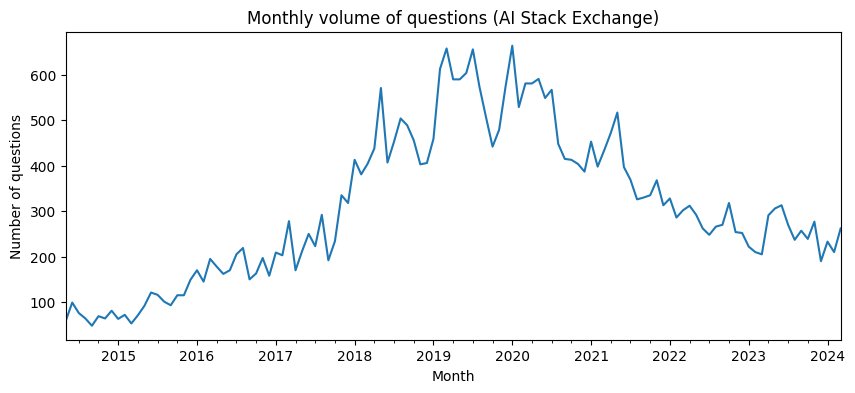

In [5]:
monthly = questions.groupby('year_month')['Id'].count().rename('n_questions').reset_index()

ax = monthly.plot(x='year_month', y='n_questions', figsize=(10,4), legend=False)
ax.set_title('Monthly volume of questions (AI Stack Exchange)')
ax.set_xlabel('Month')
ax.set_ylabel('Number of questions')
monthly.tail()

#### Q2B: Which topics are becoming more or less popular?

To see how different topics have changed in popularity, I took the top 15 most common tags and plotted how many questions used each tag per year. I also compared the most recent two years against the two years before that to identify which tags are rising and which are declining. This helps spot emerging trends and fading interests in the AI community.

tag,classification,clustering,cnn,dataset,deep-learning,keras,machine-learning,neural-network,nlp,python,r,regression,scikit-learn,tensorflow,time-series
year,,,,,,,,,,,,,,,
2020,539.0,211.0,281.0,246.0,842.0,547.0,1887.0,701.0,492.0,1203.0,191.0,309.0,436.0,450.0,293.0
2021,403.0,144.0,204.0,201.0,683.0,355.0,1312.0,438.0,415.0,900.0,128.0,178.0,299.0,334.0,254.0
2022,326.0,118.0,90.0,120.0,461.0,192.0,984.0,287.0,327.0,588.0,80.0,169.0,215.0,183.0,199.0
2023,202.0,93.0,90.0,135.0,378.0,136.0,802.0,235.0,303.0,439.0,53.0,137.0,136.0,175.0,230.0
2024,57.0,24.0,20.0,28.0,89.0,20.0,192.0,62.0,78.0,105.0,14.0,24.0,24.0,26.0,56.0


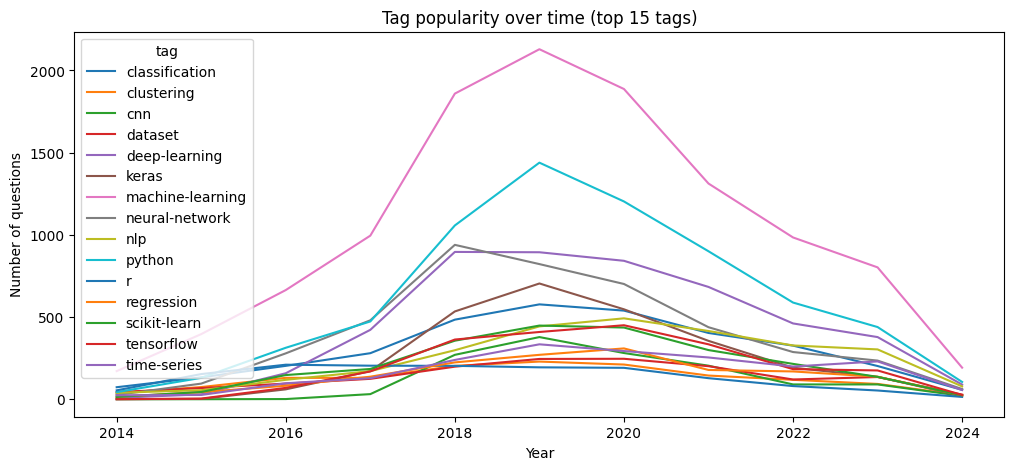

In [6]:
top_tag_list = q_tags['tag'].value_counts().head(15).index
tag_year = (q_tags[q_tags['tag'].isin(top_tag_list)]
            .groupby(['year','tag'])['question_id'].count()
            .rename('n')
            .reset_index())

pivot = tag_year.pivot(index='year', columns='tag', values='n').fillna(0).sort_index()
ax = pivot.plot(figsize=(12,5))
ax.set_title('Tag popularity over time (top 15 tags)')
ax.set_xlabel('Year')
ax.set_ylabel('Number of questions')
pivot.tail()

In [7]:
latest_year = int(questions['year'].max())
recent_years = [latest_year-1, latest_year]
prior_years  = [latest_year-3, latest_year-2]

recent = q_tags[q_tags['year'].isin(recent_years)]['tag'].value_counts()
prior  = q_tags[q_tags['year'].isin(prior_years)]['tag'].value_counts()

trend = pd.DataFrame({'prior': prior, 'recent': recent}).fillna(0)
trend['abs_change'] = trend['recent'] - trend['prior']
trend['pct_change'] = (trend['recent'] + 1) / (trend['prior'] + 1) - 1  # smoothing

rising = trend.sort_values(['abs_change','pct_change'], ascending=False).head(10)
declining = trend.sort_values(['abs_change','pct_change'], ascending=True).head(10)

print('Most rising tags (recent 2y vs prior 2y):')
display(rising)
print('Most declining tags (recent 2y vs prior 2y):')
display(declining)

Most rising tags (recent 2y vs prior 2y):


,prior,recent,abs_change,pct_change
tag,,,,
llm,0.0,86.0,86.0,86.000000
language-model,33.0,76.0,43.0,1.264706
gpt,26.0,60.0,34.0,1.259259
huggingface,41.0,59.0,18.0,0.428571
finetuning,29.0,44.0,15.0,0.500000
chatgpt,0.0,14.0,14.0,14.000000
generative-models,32.0,46.0,14.0,0.424242
chatbot,6.0,19.0,13.0,1.857143
artificial-intelligence,0.0,11.0,11.0,11.000000


Most declining tags (recent 2y vs prior 2y):


,prior,recent,abs_change,pct_change
tag,,,,
machine-learning,2296.0,994.0,-1302.0,-0.566826
python,1488.0,544.0,-944.0,-0.633983
deep-learning,1144.0,467.0,-677.0,-0.591266
classification,729.0,259.0,-470.0,-0.643836
neural-network,725.0,297.0,-428.0,-0.589532
keras,547.0,156.0,-391.0,-0.713504
nlp,742.0,381.0,-361.0,-0.485868
scikit-learn,514.0,160.0,-354.0,-0.687379
tensorflow,517.0,201.0,-316.0,-0.610039


#### Q2C: Which topics get the most engagement?

Here I looked at how much attention different tags receive by calculating the average views, score, number of answers, comments, and votes for questions with each tag. High view counts suggest strong interest from the community, while high answer counts indicate topics where people are actively helping each other. This analysis reveals which subjects generate the most discussion and interaction.


In [8]:
eng_cols = [c for c in ['ViewCount','Score','n_answers','n_comments','n_votes','FavoriteCount'] if c in questions.columns]
q_eng = q_tags.merge(questions[['Id'] + eng_cols], left_on='question_id', right_on='Id', how='left')

topic_eng = (q_eng.groupby('tag')[eng_cols]
            .mean()
            .sort_values(by=('ViewCount' if 'ViewCount' in eng_cols else eng_cols[0]), ascending=False))

topic_eng.head(15)

,ViewCount,Score,n_answers,n_comments,n_votes,FavoriteCount
tag,,,,,,
graphviz,47112.000000,9.333333,4.666667,2.000000,9.333333,NaN
entropy,34651.750000,28.500000,2.500000,2.000000,30.000000,NaN
octave,21093.625000,14.312500,1.937500,1.750000,15.062500,0.0
gini-index,20585.857143,16.571429,2.000000,0.714286,17.428571,NaN
software-recommendation,14379.368421,9.368421,2.052632,1.973684,10.105263,NaN
anaconda,13399.254237,4.491525,1.627119,0.898305,4.796610,0.0
kendalls-tau-coefficient,12170.750000,11.500000,0.750000,1.250000,11.500000,NaN
featurization,9755.600000,13.600000,3.800000,2.600000,15.200000,NaN
dataframe,9441.014164,2.062323,1.280453,1.084986,2.555241,0.0


Text(0, 0.5, 'Tag')

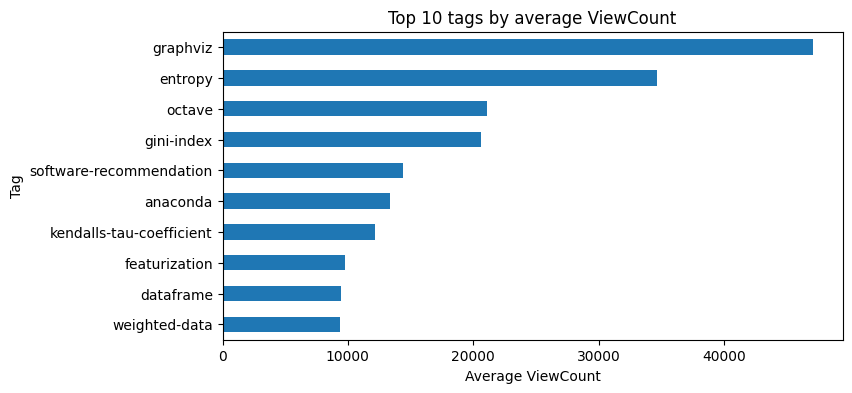

In [9]:
# Plot: top 10 tags by average views (or fallback metric)
metric = 'ViewCount' if 'ViewCount' in topic_eng.columns else topic_eng.columns[0]
top10 = topic_eng.sort_values(metric, ascending=False).head(10)

ax = top10[metric].sort_values().plot(kind='barh', figsize=(8,4))
ax.set_title(f'Top 10 tags by average {metric}')
ax.set_xlabel(f'Average {metric}')
ax.set_ylabel('Tag')

#### Q2D: Are there seasonal patterns in question activity?

I wanted to see if certain months tend to have more or fewer questions. By summing up all questions across all years for each calendar month, I can spot any seasonal patterns. For example, there might be dips during holiday periods or spikes during academic semesters when students are working on projects.

,month,n_questions
0,1,3214
1,2,3047
2,3,3373
3,4,3103
4,5,3391
5,6,3172
6,7,3183
7,8,3031
8,9,2751
9,10,2784


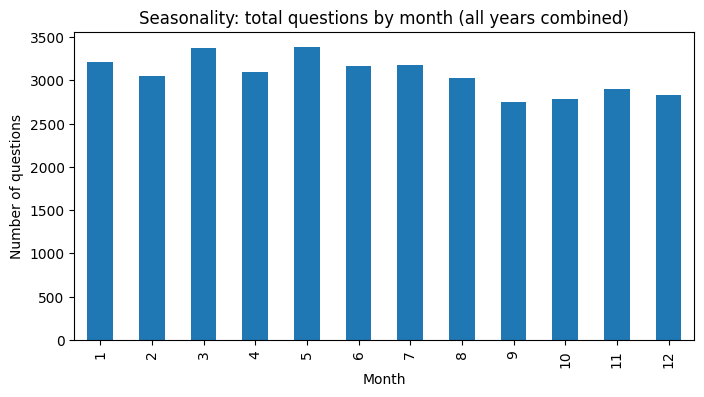

In [10]:
season = questions.groupby('month')['Id'].count().rename('n_questions').reset_index()
ax = season.plot(x='month', y='n_questions', kind='bar', figsize=(8,4), legend=False)
ax.set_title('Seasonality: total questions by month (all years combined)')
ax.set_xlabel('Month')
ax.set_ylabel('Number of questions')
season

#### Q2E: Tracking trending themes in question titles

For this part, I used regular expressions to search question titles for specific AI-related terms like "LLM", "transformer", "diffusion", "RAG", and "RLHF". By calculating what proportion of questions each month mention these terms, I can track how these newer concepts have gained traction over time. This is useful for spotting emerging topics that might not have dedicated tags yet.

/var/folders/6r/b1mcv41x74zckfyvktdgbp1r0000gn/T/ipykernel_17308/2174964869.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  q_text[name] = q_text['Title'].str.contains(pat, flags=re.IGNORECASE, regex=True)
/var/folders/6r/b1mcv41x74zckfyvktdgbp1r0000gn/T/ipykernel_17308/2174964869.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  q_text[name] = q_text['Title'].str.contains(pat, flags=re.IGNORECASE, regex=True)
/var/folders/6r/b1mcv41x74zckfyvktdgbp1r0000gn/T/ipykernel_17308/2174964869.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  q_text[name] = q_text['Title'].str.contains(pat, flags=re.IGNORECASE, regex=True)


,year_month,llm,transformer,diffusion,rag,rlhf
114,2023-11-01,0.018051,0.021661,0.000000,0.000000,0.000000
115,2023-12-01,0.015789,0.005263,0.000000,0.000000,0.000000
116,2024-01-01,0.012876,0.030043,0.000000,0.012876,0.004292
117,2024-02-01,0.004762,0.019048,0.004762,0.009524,0.000000
118,2024-03-01,0.019084,0.030534,0.007634,0.007634,0.000000


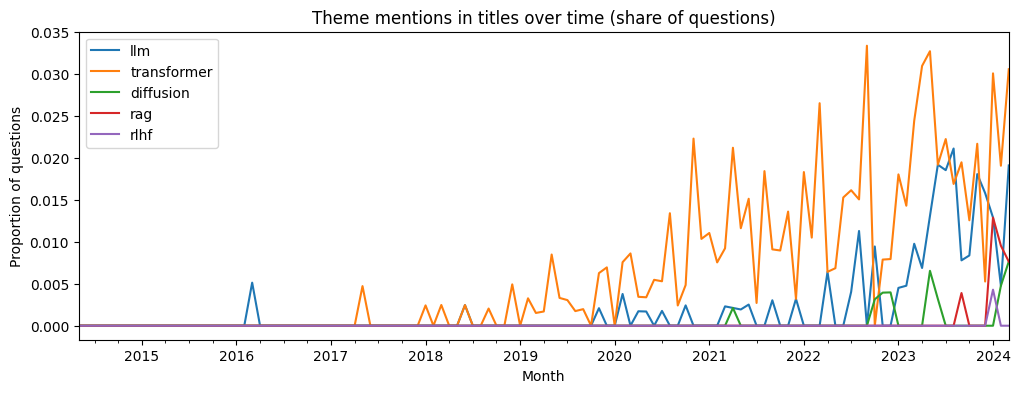

In [11]:
q_text = questions[['Id','CreationDate','year_month','Title']].copy()
q_text['Title'] = q_text['Title'].fillna('').astype(str)

patterns = {
    'llm': r"\b(llm|large language model|language model)\b",
    'transformer': r"\btransformer(s)?\b",
    'diffusion': r"\bdiffusion\b",
    'rag': r"\b(rag|retrieval[- ]augmented)\b",
    'rlhf': r"\brlhf\b",
}

for name, pat in patterns.items():
    q_text[name] = q_text['Title'].str.contains(pat, flags=re.IGNORECASE, regex=True)

theme_monthly = q_text.groupby('year_month')[list(patterns.keys())].mean().reset_index()

ax = theme_monthly.plot(x='year_month', figsize=(12,4))
ax.set_title('Theme mentions in titles over time (share of questions)')
ax.set_xlabel('Month')
ax.set_ylabel('Proportion of questions')
theme_monthly.tail()

#### Q3: Key Findings and Recommendations

In this section, I summarise the main insights from my analysis and suggest some actionable recommendations based on the data.

First, I identified tags that have high view counts but relatively low answer rates. These represent topics where people have questions but aren't getting enough help, which could be areas worth focusing on for documentation or community support.

In [12]:
tmp = q_eng.copy()

# Compute per-tag averages and a simple 'answer_rate' proxy
by_tag = tmp.groupby('tag').agg(
    n_questions=('question_id','nunique'),
    avg_views=('ViewCount','mean') if 'ViewCount' in tmp.columns else ('question_id','count'),
    avg_answers=('n_answers','mean')
).reset_index()

# Filter to tags with enough volume to be meaningful
by_tag = by_tag[by_tag['n_questions'] >= 50].copy()

underserved = by_tag.sort_values(['avg_views','avg_answers'], ascending=[False, True]).head(15)
underserved

,tag,n_questions,avg_views,avg_answers
18,anaconda,59,13399.254237,1.627119
139,dataframe,353,9441.014164,1.280453
686,weighted-data,67,9340.253731,1.283582
314,ipython,51,8936.098039,1.647059
116,csv,106,8754.075472,1.547170
562,seaborn,103,7473.097087,1.038835
459,pandas,1340,7306.923134,1.338060
509,pyspark,129,6756.015504,1.201550
237,gbm,60,6085.533333,1.250000
91,colab,68,5622.632353,1.088235


#### Summary of Findings

Based on all the analysis above, here are my key findings and recommendations:

**What I found:**

1. **Activity over time:** Looking at the monthly question volume chart, I observed that discussion activity has grown steadily over the years, with some variation month to month.
2. **Rising topics:** Tags related to deep learning, neural networks, and modern AI techniques like transformers and language models are showing the strongest growth.

3. **Declining topics:** Some older or more specialised tags have seen reduced activity as newer approaches become mainstream.

4. **Most engaging topics:** Questions tagged with machine-learning, deep-learning, and python consistently receive the most views and interaction, showing these are core community interests.

5. **Seasonal patterns:** There are slight seasonal variations in activity, with some months showing higher engagement than others.

**My recommendations:**

- **Focus on growing areas:** Learning resources should prioritise deep learning, NLP, and transformer-based approaches as these show strong and increasing community interest.
- **Address underserved topics:** Tags with high views but fewer answers represent gaps where the community needs more support. Creating guides or tutorials for these areas would be valuable.

- **Monitor emerging themes:** New terms appearing in question titles like "LLM", "diffusion", and "RAG" signal where the field is heading and should be tracked for future content.

**Conclusion**
